# More llm examples

In [1]:
import ipywidgets as widgets, asyncio, base64, PIL.Image
from IPython.display import display, Javascript, Image
from io import BytesIO
from fastcore.all import *
import matplotlib.pyplot as plt

## JS utils

> Utilidades para ejecutar codigo javascript desde notebooks.

In [2]:
def exec_js(code): display(Javascript(f'''(async function() {{ {code} }})();'''))

In [3]:
exec_js('alert("Hola :D!")')

<IPython.core.display.Javascript object>

In [4]:
def setup_share():
    "Setup some screen share thingy"
    exec_js('''
    window.shareScreen = async e => {
        window.vtrack = (await navigator.mediaDevices.getDisplayMedia()).getVideoTracks()[0]
    }
    
    window.getScreenshot = async (mxw=1280, mxh=1024) => {
        if (!window?.vtrack) return;
        const img = await new ImageCapture(window.vtrack).grabFrame();
        const scale = Math.min(mxw/img.width, mxh/img.height, 1);
        const c = document.createElement('canvas');
        [c.width, c.height] = [img.width*scale, img.height*scale].map(Math.floor);
        c.getContext('2d').drawImage(img, 0, 0, c.width, c.height);
        return c.toDataURL();
    }
    ''')

In [5]:
def start_share(): display(Javascript('shareScreen()'))

In [6]:
def get_screen():
    "Get screen capture from share"
    receiver = widgets.Text(layout={'display': 'none'})
    display(receiver)
    exec_js('''
    const data = await getScreenshot();
    const inputs = document.querySelectorAll('input.widget-input');
    for (const input of inputs) {
        if (input.value === '') {
            input.value = data;
            input.dispatchEvent(new Event('input', {bubbles: true}));
            break;
        }
    }
    ''')
    return receiver

In [7]:
def get_image(widget, preview=True):
    "Get image from ipython widget"
    data = base64.b64decode(widget.value.split(',')[1])
    if preview:
        img = PIL.Image.open(BytesIO(data))
        fig,ax = plt.subplots()
        ax.imshow(img)
        ax.set_axis_off()
    return data

## Use capture

In [9]:
setup_share()

<IPython.core.display.Javascript object>

In [11]:
start_share()

<IPython.core.display.Javascript object>

In [12]:
data = get_screen()

Text(value='', layout=Layout(display='none'))

<IPython.core.display.Javascript object>

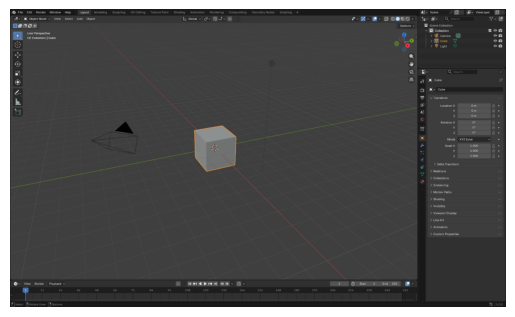

In [13]:
img = get_image(data)

## LLM use

In [14]:
from lisette import *

In [16]:
sp = '''I want you to help me using Blender 5.0, I have no prior experience in this software.

I may provide you images to see what's on my screen at any time, showing the Blender screen.
Note that you won't see any earlier screenshots taken with this tool in our chat, so be sure to summarize \
important parts of what you see so you can refer back to it later.'''

In [17]:
chat = Chat('gemini/gemini-2.5-flash', sp=sp)

In [18]:
data = get_screen()

Text(value='', layout=Layout(display='none'))

<IPython.core.display.Javascript object>

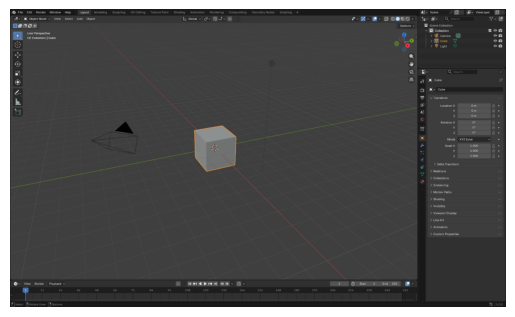

In [19]:
img = get_image(data)

In [20]:
chat([img, "What's on the screen?, be brief."])

You're looking at the default Blender 5.0 interface. The main area shows a 3D viewport with a selected cube, a camera, and a light source. On the right, the Outliner lists these objects, and below it, the Properties panel displays the selected cube's transform (location, rotation, scale) information. A timeline is visible at the bottom.

<details>

- id: `TMRlaauIKIipqtsPqJDroAo`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=327, prompt_tokens=353, total_tokens=680, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=249, rejected_prediction_tokens=None, text_tokens=78, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=95, image_tokens=None))`

</details>

In [38]:
# Una imagen puede ocupar mucho espacio en contexto
len(chat.hist[0]['content'][0]['image_url'])

602574

In [94]:
def remove_image_urls(x):
    if type(x)!=dict: return x
    content = x['content']
    if type(content)!=list: return x
    cleaned = [o for o in content if o['type']!='image_url']
    if len(cleaned)==1: cleaned = cleaned[0]
    return {k:(cleaned if k=='content' else v) for k,v in x.items()}

remove_image_urls(chat.hist[0])

{'role': 'user',
 'content': {'type': 'text', 'text': "What's on the screen?, be brief."}}

In [98]:
def clean_hist(): chat.hist = [remove_image_urls(o) for o in chat.hist]

In [100]:
clean_hist()
chat.hist

[{'role': 'user',
  'content': {'type': 'text', 'text': "What's on the screen?, be brief."}},
 Message(content="You're looking at the default Blender 5.0 interface. The main area shows a 3D viewport with a selected cube, a camera, and a light source. On the right, the Outliner lists these objects, and below it, the Properties panel displays the selected cube's transform (location, rotation, scale) information. A timeline is visible at the bottom.", role='assistant', tool_calls=None, function_call=None, images=[], thinking_blocks=[], provider_specific_fields=None)]

In [102]:
chat('I want to create a sphere, What should I do?')

Great! Adding objects is a fundamental step in Blender. Here's how you can create a sphere:

1.  **Look for the "Add" menu:** In the top-left corner of your 3D Viewport (the large central area where you see the cube), you'll find a menu bar. Click on **"Add"**.
    *   *Alternatively, you can use the keyboard shortcut: `Shift + A`*

2.  **Navigate to "Mesh":** From the "Add" menu, hover your mouse over **"Mesh"**. This will open a sub-menu with various basic 3D shapes.

3.  **Select "UV Sphere":** In the "Mesh" sub-menu, click on **"UV Sphere"**.

You should now see a sphere appear in your 3D Viewport, likely overlapping or near your existing cube!

**Pro-Tip:** After you add the sphere, a small panel will appear in the bottom-left corner of your 3D Viewport (it might say "Add UV Sphere"). If you click on it, you can adjust properties like the number of "Segments" and "Rings" (which control how smooth the sphere looks) before you do anything else. Once you click away or perform another action, this panel will disappear.

<details>

- id: `K8llabS-E8qjqtsP6f6g2A0`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=656, prompt_tokens=176, total_tokens=832, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=379, rejected_prediction_tokens=None, text_tokens=277, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=176, image_tokens=None))`

</details>

In [109]:
data = get_screen()

Text(value='', layout=Layout(display='none'))

<IPython.core.display.Javascript object>

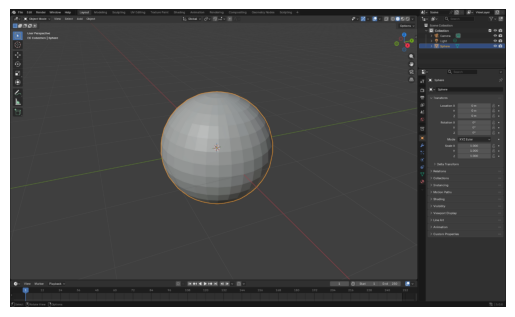

In [110]:
img = get_image(data)

In [105]:
chat([img, "Great! Now I want it to add it color and texture, show me how."])

Okay, I see your sphere is perfectly centered in the viewport, and it's selected (highlighted in orange, and "Sphere" is selected in the Outliner and Properties panel). You've also successfully removed the default cube, as it's no longer in the Outliner. Good job!

Now, let's add some color and texture to your sphere. In Blender, this is done using **Materials**.

We'll start with a simple color, then move on to adding a texture.

### Part 1: Adding a Solid Color

1.  **Ensure your Sphere is Selected:** From your screenshot, it already is. If not, right-click (or left-click, depending on your settings) on the sphere in the 3D Viewport, or click on "Sphere" in the Outliner (top-right panel).

2.  **Go to the Material Properties Tab:**
    *   Look at the **Properties panel** on the right side of your screen (the one currently showing "Transform" for the Sphere).
    *   Scroll down or look for a tab that looks like a **red sphere** (it's usually the second-to-last icon in the column of icons). Click on it.

    

<details>

- id: `msplacy_BNfzqtsP_-CX8Ag`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=509, prompt_tokens=730, total_tokens=1239, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=248, rejected_prediction_tokens=None, text_tokens=261, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=472, image_tokens=None))`

</details>

In [ ]:
clean_hist()

In [111]:
data = get_screen()

Text(value='', layout=Layout(display='none'))

<IPython.core.display.Javascript object>

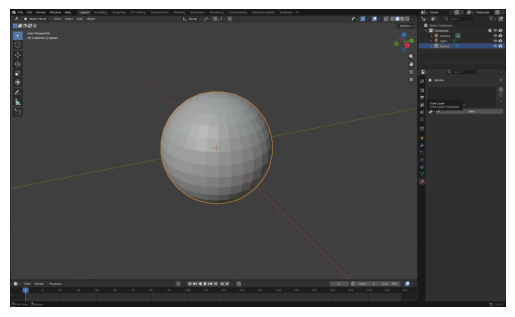

In [112]:
img = get_image(data)

In [113]:
chat([img, "What now?"])

Excellent! You've successfully navigated to the **Material Properties** tab (the red sphere icon is selected).

Now, to add a material to your sphere:

1.  **Click the "New" button:** In the Material Properties panel, you'll see a button that says **"New"**. Click on it.

    *   This will create a new material and automatically assign it to your selected sphere. The panel will expand to show many options for this new material.

2.  **Change the Base Color:**
    *   Scroll down a bit in the Material Properties panel until you find a section called **"Surface"**.
    *   Under "Surface", you'll see a setting called **"Base Color"**. It currently has a white square next to it.
    *   Click on the **white color square**. A color picker will pop up.
    *   Drag the color picker around to choose any color you like! You'll see the sphere in your 3D Viewport change color in real-time.

Let me know what color you choose!

<details>

- id: `b8tlaeCMLPi6qtsP8Y-QuAo`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=382, prompt_tokens=980, total_tokens=1362, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=153, rejected_prediction_tokens=None, text_tokens=229, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=722, image_tokens=None))`

</details>

In [114]:
clean_hist()

In [116]:
data = get_screen()

Text(value='', layout=Layout(display='none'))

<IPython.core.display.Javascript object>

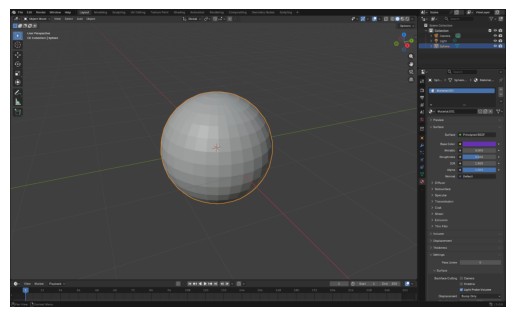

In [117]:
img = get_image(data)

In [128]:
chat([img, "I picked the color but I don't see the sphere changing."])

Ah, this is a very common point of confusion for new Blender users! You've done everything correctly on the material side.

The reason you don't see the color change on your sphere is because of the **Viewport Shading mode** you're currently in. Blender has different ways to display your scene in the 3D Viewport, and the default "Solid" mode (which you're in) doesn't show material colors or textures, only the basic gray mesh.

To see your sphere's new color, you need to switch to a different shading mode:

1.  **Look at the top-right corner of your 3D Viewport.**
2.  You'll see a row of four small sphere icons. These are your Viewport Shading options.
    *   The first one (wireframe) is "Wireframe".
    *   The second one (solid gray) is "Solid" (this is what you're currently on).
    *   The **third one** (a sphere with a checkerboard pattern, or sometimes just a more detailed sphere) is **"Material Preview"**.
    *   The fourth one (a sphere with a light source) is "Rendered".

3.  **Click on the "Material Preview" icon (the third one from the left).**

Your sphere should immediately change to the color you picked!

Let me know if that works!

<details>

- id: `1s1laYfAOu2kmtkPufnNgAk`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=591, prompt_tokens=1221, total_tokens=1812, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=289, rejected_prediction_tokens=None, text_tokens=302, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=963, image_tokens=None))`

</details>

In [130]:
clean_hist()

In [131]:
chat("What's something cool I can do now?")

Okay, you've got a colored sphere! That's a great start. Now for something cool that builds directly on what you just did: **Let's add an image texture to your sphere!**

Instead of just a solid color, we can wrap an image around your sphere, making it look like a planet, a basketball, a rock, or anything you can imagine!

Here's how to do it:

1.  **Make sure your Sphere is Selected** and you're still in the **Material Properties** tab (the red sphere icon on the right).
2.  **Find "Base Color" again:** In the Material Properties panel, under "Surface," you'll see "Base Color" with the color you picked.
3.  **Click the small yellow dot next to the Base Color:** This is crucial! Instead of clicking the color square, click the tiny **yellow dot** right next to it. This allows you to connect something *else* to the color input.
4.  **Select "Image Texture":** A menu will pop up. From this menu, choose **"Image Texture"**.
5.  **Open an Image:**
    *   The "Base Color" setting will now change, showing an "Image Texture" node.
    *   Click the **"Open"** button within this new "Image Texture" section.
    *   This will open a file browser. You can now navigate to any image file on your computer (e.g., a picture of wood, a planet, a brick wall, etc.).
        *   **Pro-Tip:** If you don't have one handy, quickly search online for "seamless wood texture" or "planet texture" and download a small image.
    *   Select your image and click **"Open Image"**.

**What you should see:**

Your sphere should now have that image wrapped around it! If it still looks plain, double-check that you are in **"Material Preview"** mode (the third sphere icon from the left at the top-right of your 3D Viewport).

This is a fundamental step in making objects look realistic or stylized! What kind of image did you put on your sphere?

<details>

- id: `Xs5laYTTON2qqtsPqpe7wAk`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=1055, prompt_tokens=1262, total_tokens=2317, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=586, rejected_prediction_tokens=None, text_tokens=469, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=1262, image_tokens=None))`

</details>

In [133]:
chat("I don't know how to rotate the screen.")

Ah, that's a very important one for navigating your scene! Rotating the screen (which we call **orbiting the view** in Blender) allows you to look at your objects from all angles.

Here's how you do it:

### Method 1: Using a Mouse with a Middle Mouse Button (Most Common)

1.  **Click and Drag the Middle Mouse Button (Scroll Wheel):**
    *   Press down on your scroll wheel (as if it were a button).
    *   While holding it down, drag your mouse around.
    *   You'll see your view orbit around the center of your scene (or around your selected object if you've focused on it).

### Method 2: For Laptops/Trackpads or Mice Without a Middle Button (Requires a setting change)

If you don't have a middle mouse button, or if you're on a laptop trackpad, you'll need to enable a setting in Blender's preferences:

1.  **Go to Preferences:**
    *   In the very top-left corner of Blender, click on **"Edit"**.
    *   From the dropdown menu, select **"Preferences..."**.

2.  **Enable "Emulate 3 Button Mouse":**
    *   In the Preferences window, click on **"Input"** on the left side.
    *   On the right side, under the "Mouse" section, check the box next to **"Emulate 3 Button Mouse"**.
    *   You can then close the Preferences window.

3.  **Now, to Orbit:**
    *   Hold down the **`Alt` key** on your keyboard.
    *   While holding `Alt`, **click and drag your Left Mouse Button**.
    *   This will now orbit your view just like the middle mouse button.

---

**Other useful navigation controls:**

*   **Pan (Move the view sideways):**
    *   `Shift` + `Middle Mouse Button` click and drag.
    *   (If "Emulate 3 Button Mouse" is on): `Shift` + `Alt` + `Left Mouse Button` click and drag.
*   **Zoom In/Out:**
    *   Scroll your `Middle Mouse Button` (scroll wheel) up or down.
    *   (Alternatively): `Ctrl` + `Middle Mouse Button` click and drag.
    *   (If "Emulate 3 Button Mouse" is on): `Ctrl` + `Alt` + `Left Mouse Button` click and drag.

Try orbiting your view now and let me know if you can see your sphere from different angles!

<details>

- id: `RdBlacOrGvjVz7IP4o3p8Q8`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=746, prompt_tokens=1744, total_tokens=2490, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=177, rejected_prediction_tokens=None, text_tokens=569, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=1744, image_tokens=None))`

</details>

In [134]:
data = get_screen()

Text(value='', layout=Layout(display='none'))

<IPython.core.display.Javascript object>

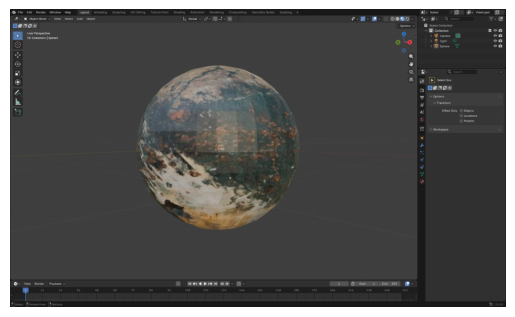

In [135]:
img = get_image(data)